In [1]:
## Breast Cancer Classification Transfer Learning VGG16
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn
import tensorflow as tf

from sklearn.utils import class_weight  # Import class_weight
from sklearn.metrics import confusion_matrix, classification_report

2025-05-07 14:55:12.833420: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-07 14:55:12.849809: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-07 14:55:12.857410: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-07 14:55:12.876257: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-07 14:55:13.865224: W tensorflow/compiler/tf2

In [2]:
### Creating Dataset
print(os.listdir('../breast_full_dataset'))

### Train Test Split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as base_preprocess

['Benign', 'Malignant']


In [3]:
image_gen = ImageDataGenerator(
                               #preprocessing_function=base_preprocess,
                               validation_split=0.15)
data_dir = "../breast_full_dataset"
batch_size = 8
target_size = (224,224)

train_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size,
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          subset="training")

test_image_gen = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False,
                                          subset="validation")
image = image_gen.flow_from_directory(data_dir, 
                                          target_size=target_size, 
                                          color_mode='rgb',
                                          batch_size=batch_size,
                                          class_mode='categorical',
                                          shuffle=False)

Found 6488 images belonging to 2 classes.
Found 1144 images belonging to 2 classes.
Found 7632 images belonging to 2 classes.


In [4]:
# Here, we add random rotation, zoom, brightness, vertical flip, etc.
image_gen = ImageDataGenerator(
    preprocessing_function=base_preprocess,
    validation_split=0.15,
    rotation_range=20,        # Random rotation in degrees
    #zoom_range=0.1,           # Random zoom
    brightness_range=[1.0, 1.5],  # Brightness adjustment
    vertical_flip=True,       # Flip vertically
)

data_dir = "../breast_full_dataset"
batch_size = 8
target_size = (224, 224)

train_image_gen = image_gen.flow_from_directory(
    data_dir,
    target_size=target_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset="training"
)

test_image_gen = image_gen.flow_from_directory(
    data_dir,
    target_size=target_size,
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False,
    subset="validation"
)

Found 6488 images belonging to 2 classes.
Found 1144 images belonging to 2 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.24705887].


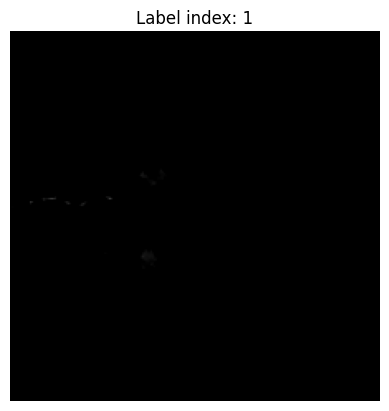

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.13725495].


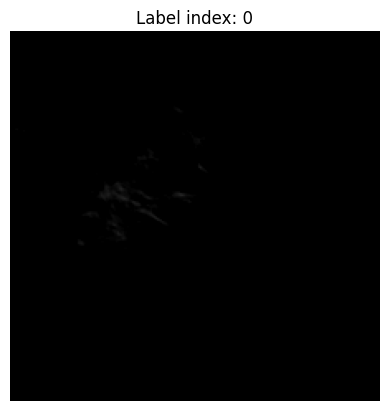

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.3803922].


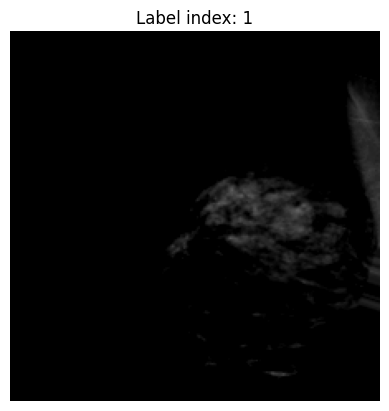

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8666667].


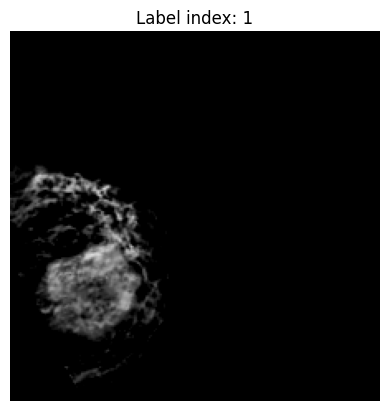

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.8039216..0.8980392].


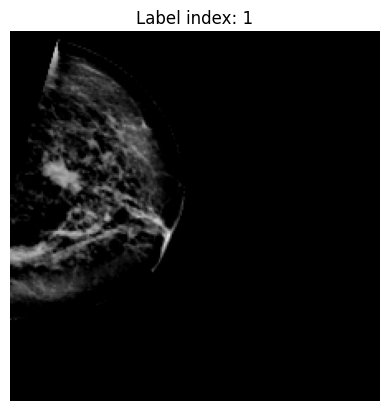

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


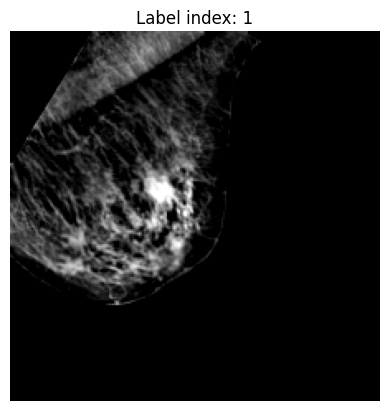

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.28627455].


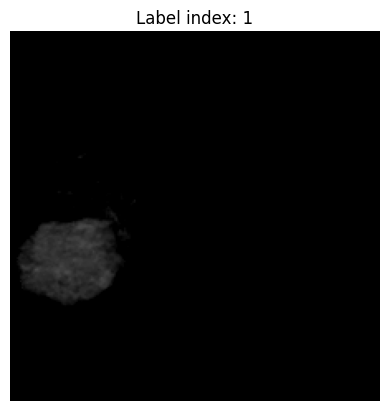

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.27843142].


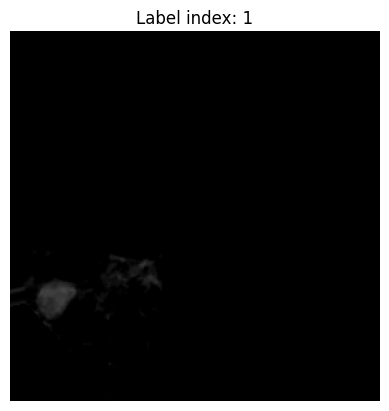

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Fetch a batch of images (and their labels) from the training generator
images, labels = next(train_image_gen)  # images.shape == (batch_size, height, width, channels)

# Display the first 5 images (or as many as you like)
num_to_show = len(images)
for i in range(num_to_show):
    plt.figure()  # Create a new figure for each image
    plt.imshow(images[i])  # Convert floats to uint8 for display (if needed)
    plt.title(f"Label index: {np.argmax(labels[i])}")  # Convert one-hot to class index (if categorical)
    plt.axis('off')
    plt.show()


In [13]:
print(test_image_gen.class_indices)
train_labels = train_image_gen.classes  # Extracts the classes (integer encoded labels)

{'Benign': 0, 'Malignant': 1}


In [14]:
# Get the unique class names and their corresponding indices
class_names = list(train_image_gen.class_indices.keys())
print(f"Class names: {class_names}")

Class names: ['Benign', 'Malignant']


In [15]:
# Compute class weights based on the labels
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(train_labels),
                                                  y=train_labels)

# Create a dictionary mapping class indices to weights
class_wt_dict = dict(enumerate(class_weights))

# Output the computed class weights
print(f"Class weights: {class_wt_dict}")

Class weights: {0: np.float64(1.5144724556489262), 1: np.float64(0.7464335020708698)}


In [7]:
## Transfer Learning using VGG16 Model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.layers import Flatten, Dense, Input, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

x_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in x_model.layers[:-1]:
    layer.trainable = False

x = x_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(2, activation='sigmoid')(x)
tl_model = Model(inputs=x_model.input, outputs=x)

optimizer = "Adam"
tl_model.summary()
tl_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

I0000 00:00:1740639448.613942   19673 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4778 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 111, 111,  │        864 │ input_layer[0][0] │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_bn     │ (None, 111, 111,  │        128 │ block1_conv1[0][… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1_act    │ (None, 111, 111,  │          0 │ block1_conv1_bn[… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 109, 109,  │     18,432 │ block1_conv1_act… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_bn     │ (None, 109, 109,  │        256 │ block1_conv2[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2_act    │ (None, 109, 109,  │          0 │ block1_conv2_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1     │ (None, 109, 109,  │      8,768 │ block1_conv2_act… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv1_bn  │ (None, 109, 109,  │        512 │ block2_sepconv1[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_act │ (None, 109, 109,  │          0 │ block2_sepconv1_… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2     │ (None, 109, 109,  │     17,536 │ block2_sepconv2_… │
│ (SeparableConv2D)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_sepconv2_bn  │ (None, 109, 109,  │        512 │ block2_sepconv2[… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 55, 55,    │      8,192 │ block1_conv2_act… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 55, 55,    │          0 │ block2_sepconv2_… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 55,    │        512 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 55, 55,    │          0 │ block2_pool[0][0… │
│                     │ 128)              │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_sepconv1_act │ (None, 55, 55,    │          0 │ add[0][0]       

 Total params: 72,245,290 (275.59 MB)

 Trainable params: 51,382,786 (196.01 MB)

 Non-trainable params: 20,862,504 (79.58 MB)

In [16]:
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [17]:
# Clear the session
tf.keras.backend.clear_session()

# Reset the tracked memory stats
tf.config.experimental.reset_memory_stats('GPU:0')

In [10]:
## Model Training
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard

filename = "models3/t3_breast_Xception_NoPreProcess-lrreduceP4-epoch{epoch:02d}.keras"
dirname = "logs_test3/breast_XceptionAdam_NoPreProcessing_lrreduceP4"

lr_reduce = ReduceLROnPlateau(monitor='val_accuracy', factor=0.6, patience=4,mode='max', min_lr=0.00001,verbose=1)
early_stop = EarlyStopping(monitor="val_loss", patience=5, verbose=1)
model_chkpt = ModelCheckpoint(filepath= filename, save_best_only=True, monitor='val_accuracy',verbose=1)
tensorboard = TensorBoard(log_dir=dirname, histogram_freq=1)

#callback_list = [model_chkpt, lr_reduce, early_stop, tensorboard]
callback_list = [model_chkpt, lr_reduce, tensorboard]
history = tl_model.fit(train_image_gen,
                    epochs=20, 
                    validation_data = test_image_gen,
                    class_weight=class_wt_dict,
                    callbacks=callback_list)

/home/mr/workspace/MajorProject/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1740221138.318156   60134 service.cc:148] XLA service 0x719d840102b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740221138.318174   60134 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-02-22 16:15:38.432789: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1740221139.260540   60134 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-02-22 16:15:40.840734: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.36GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2025-02-22 16:15:41.249805: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:306] Allocator (GPU_0_bfc) ran out

  3/811 ━━━━━━━━━━━━━━━━━━━━ 30s 38ms/step - accuracy: 0.4444 - loss: 1.4921  

I0000 00:00:1740221143.033308   60134 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.5288 - loss: 0.9031
Epoch 1: val_accuracy improved from -inf to 0.53759, saving model to models3/t3_breast_Xception_NoPreProcess-lrreduceP4-epoch01.keras


2025-02-22 16:16:42.128564: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12331253760 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 72s 78ms/step - accuracy: 0.5288 - loss: 0.9030 - val_accuracy: 0.5376 - val_loss: 0.7472 - learning_rate: 0.0010
Epoch 2/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5826 - loss: 0.7071
Epoch 2: val_accuracy improved from 0.53759 to 0.57517, saving model to models3/t3_breast_Xception_NoPreProcess-lrreduceP4-epoch02.keras


2025-02-22 16:18:38.408518: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12331253760 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 117s 144ms/step - accuracy: 0.5826 - loss: 0.7071 - val_accuracy: 0.5752 - val_loss: 0.6917 - learning_rate: 0.0010
Epoch 3/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.5835 - loss: 0.6819
Epoch 3: val_accuracy did not improve from 0.57517


2025-02-22 16:21:08.434944: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12331253760 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 150s 185ms/step - accuracy: 0.5835 - loss: 0.6819 - val_accuracy: 0.4441 - val_loss: 0.8095 - learning_rate: 0.0010
Epoch 4/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.6242 - loss: 0.6425
Epoch 4: val_accuracy did not improve from 0.57517


2025-02-22 16:24:26.925444: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12331253760 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 198s 244ms/step - accuracy: 0.6242 - loss: 0.6425 - val_accuracy: 0.5341 - val_loss: 0.7173 - learning_rate: 0.0010
Epoch 5/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.6269 - loss: 0.6374
Epoch 5: val_accuracy did not improve from 0.57517


2025-02-22 16:27:47.209510: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 12331253760 exceeds 10% of free system memory.


811/811 ━━━━━━━━━━━━━━━━━━━━ 202s 249ms/step - accuracy: 0.6269 - loss: 0.6374 - val_accuracy: 0.5402 - val_loss: 0.7307 - learning_rate: 0.0010
Epoch 6/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.6563 - loss: 0.6225
Epoch 6: val_accuracy did not improve from 0.57517

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0006000000284984708.
811/811 ━━━━━━━━━━━━━━━━━━━━ 216s 267ms/step - accuracy: 0.6563 - loss: 0.6225 - val_accuracy: 0.5323 - val_loss: 0.7421 - learning_rate: 0.0010
Epoch 7/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.6631 - loss: 0.6016
Epoch 7: val_accuracy did not improve from 0.57517
811/811 ━━━━━━━━━━━━━━━━━━━━ 226s 278ms/step - accuracy: 0.6631 - loss: 0.6016 - val_accuracy: 0.5122 - val_loss: 0.7962 - learning_rate: 6.0000e-04
Epoch 8/20
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step - accuracy: 0.6894 - loss: 0.5674
Epoch 8: val_accuracy did not improve from 0.57517
811/811 ━━━━━━━━━━━━━━━━━━━━ 233s 288ms/step - accuracy: 0.6894 - l

143/143 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.5147 - loss: 1.0130
143/143 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step


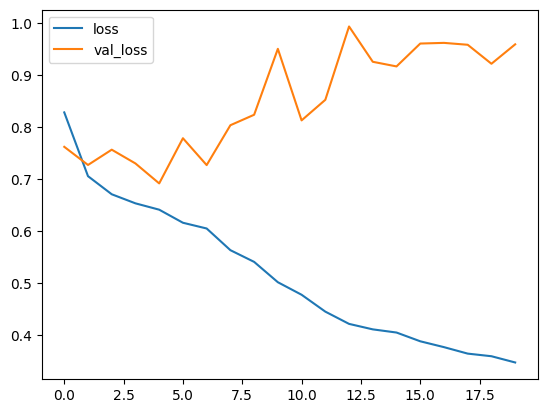

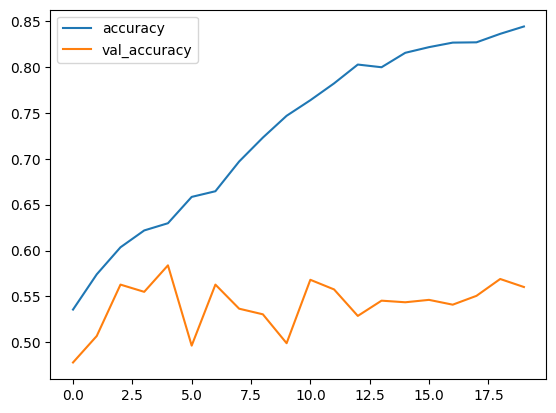

In [11]:
### Model Evaluation
df=pd.DataFrame(tl_model.history.history)
df.to_csv('hist2.csv')
metrics = pd.DataFrame(tl_model.history.history)
metrics[["loss","val_loss"]].plot()
metrics[["accuracy","val_accuracy"]].plot()
tl_model.evaluate(test_image_gen)
predictions = tl_model.predict(test_image_gen, verbose=1)
predictions = predictions.argmax(axis=1)

In [18]:
test_labels = image.classes
from tensorflow.keras.models import load_model

final_model = load_model("./final models/t3_breast_Xception_NoPreProcess-lrreduceP4-epoch02.keras")
predictions = final_model.predict(image, verbose=1)
predictions = predictions.argmax(axis=1)
test_labels = image.classes

/home/mr/workspace/MajorProject/.venv/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


954/954 ━━━━━━━━━━━━━━━━━━━━ 37s 37ms/step


Normalized confusion matrix
[[0.57301587 0.42698413]
 [0.34037559 0.65962441]]
              precision    recall  f1-score   support

           0       0.45      0.57      0.51      2520
           1       0.76      0.66      0.71      5112

    accuracy                           0.63      7632
   macro avg       0.61      0.62      0.61      7632
weighted avg       0.66      0.63      0.64      7632



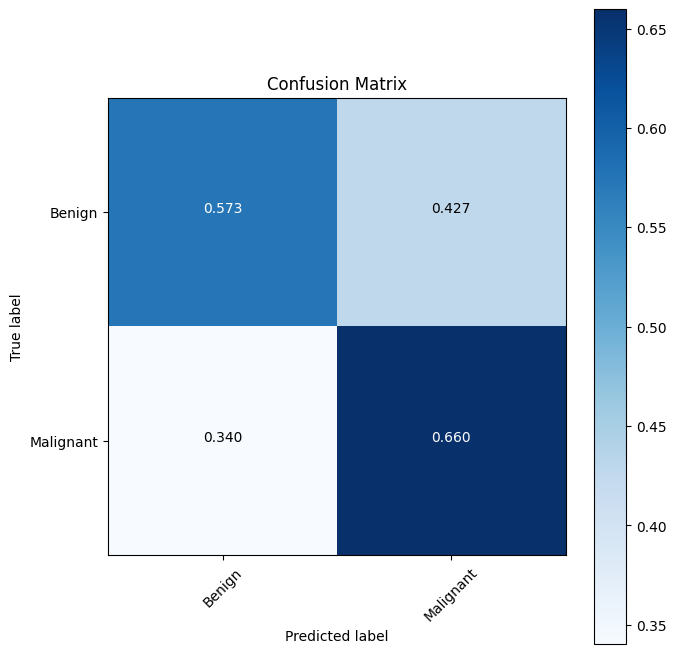

In [19]:
cm = confusion_matrix(test_labels, predictions)
cm
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.figure(figsize=(7,7))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.3f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > 0.5 else "black")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
cm_plot_labels = list(image.class_indices.keys())

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix', normalize=True)
print(classification_report(image.classes, predictions, zero_division=0))


In [11]:
print(classification_report(test_labels, predictions))

              precision    recall  f1-score   support

           0       0.50      0.65      0.57       378
           1       0.80      0.68      0.73       766

    accuracy                           0.67      1144
   macro avg       0.65      0.66      0.65      1144
weighted avg       0.70      0.67      0.68      1144

